In [65]:
#imports from rdkit and iPython
import rdkit
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem.Draw.MolDrawing import MolDrawing, DrawingOptions
from rdkit import rdBase, Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import rdMolDraw2D 
from rdkit.Chem.Draw import MolDraw2D
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import AtomPairs
from rdkit.Chem.AtomPairs import Torsions
from rdkit.Chem import rdchem
from rdkit.Chem import rdqueries
from rdkit.Chem.rdchem import EditableMol
from rdkit.Chem.rdchem import Atom
from rdkit.Chem import rdmolops
from rdkit.Chem import MolFromSmiles
from rdkit.Chem.Draw import MolsToGridImage
from IPython.display import display #python notebook display

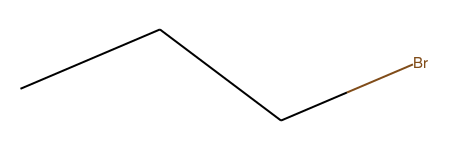

In [66]:
#Shows an example of a SMILES string being displayed as a molecule
smilesMol = Chem.MolFromSmiles('CCCBr')
smilesMol

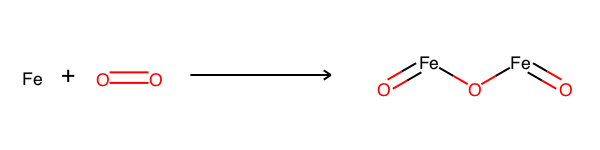

In [67]:
#Shows how SMARTS reaction works
rxn = AllChem.ReactionFromSmarts('[Fe].O=O>>O=[Fe]O[Fe]=O',useSmiles=True)
rxn

In [68]:
#SN2 Algorithm

In [69]:
# Dictionaries of Nucleophiles and Leaving Groups with common name of molecule with its SMILES string
listOfNucs = {'Sodium Hydroxide':'[OH-].[Na+]', 'Sodium Methoxide':'C[O-].[Na+]', 'Methyllithium':'[Li]C', 
              'Potassium Hydroxide':'[OH-].[K+]', 'Sodium Cyanide':'[Na+].[C-]#N', 'Potassium Cyanide':'[K+].[C-]#N', 
              'Sodium Acetylide':'C#[C-].[Na+]', 'Sodium Amide':'[NH2-].[Na+]',
             'Sodium Iodide':'[Na+].[I-]', 'Lithium Bromide':'[Li+].[Br-]', 'Potassium Iodide':'[K+].[I-]', 
              'Sodium Azide':'[Na+].[N-]=[N+]=[N-]', 'Sodium Ethoxide':'[Na+].CC[O-]'}
listOfLG = {'Bromine':'Br', 'Chloride':'Cl', 'Iodide':'I', 'Water':'O','Sulfonic Acid':'O[S]([O-])=O', 
            'Hydrogen Sulfate':'O[S]([O-])(=O)=O', 'Ammonia':'N'} 

In [70]:
#Function that find the reactant that is a nucleophile
def findNuc(reac1, reac2):
    nuc = ''
    for key, value in listOfNucs.items():
        if reac1 == value or reac2 == value:
            nuc = value
            
            break
    
    if nuc == '':
        print('Neither of the reactants entered are nucleophiles')
    
    return nuc

#Function that finds the leaving group in the reactants specified
def findLG(reac1, reac2):
    lg = ''
    leaving_group = ''
    reac = findNuc(reac1, reac2)
    if reac == reac1:
        lg = reac2
    else: 
        lg = reac1
        
    for key, value in listOfLG.items():
        if value in lg:
            leaving_group = value
            
            break
    if leaving_group == '':
        print('Neither of the reactants entered are leaving groups')
    
    return leaving_group

#Finds the reactant with the substrate
def findReactant(reac1, reac2):
    attack = ''
    reac = findNuc(reac1, reac2)
    if reac == reac1:
        attack = reac2
    else: 
        attack = reac1

    print("Your substrate is: ", attack)
    attack1 = Chem.MolFromSmiles(attack)
    
    return attack1

#Function that finds a negatively charged molecule
def findNeg(reac):
    m = Chem.MolFromSmiles(reac)
    qa = rdqueries.FormalChargeGreaterQueryAtom(0)
    keep = [x for x in Chem.GetMolFrags(m,asMols=True) if not len(x.GetAtomsMatchingQuery(qa))]
    x = [Chem.MolToSmiles(x) for x in keep]
    return x

#Function that adds the proper format to the string for it to be a SMILES molecule
import re
def stripNew(reac):
    reac = re.sub("H","",reac)
    neg = findNeg(reac)

    neg = neg[0]
    
    neg = re.sub("-","",neg)
    neg = re.sub("\[","",neg)
    neg = re.sub("\]","",neg)
    
    return neg
#Function that makes a leaving group more readable 
def makeIon(lg):
    reac = re.sub("H","",lg)
    
    reac = ('[' + reac +'-]')
    return reac

In [71]:
#Main function that performs the subsitution reaction
def subs(reac1, reac2):
    nucleophile = findNuc(reac1, reac2)
    print("The strong nucleophile is: ", nucleophile) #finds the nucleophile from the two reactants given
    display(Chem.MolFromSmiles(nucleophile))
    leaving_g = findLG(reac1, reac2) #finds the reactant with the leaving group
    ion = makeIon(leaving_g) #makes the leaving group in a more readable format
    print("The leaving group is: ", ion)
    display(Chem.MolFromSmiles(ion))
    
    
    if nucleophile == '[Na+].CC[O-]': #An exception to the nucleophiles. Sodium ethoxide needs to be formatted differently because of the position of oxygen
        r = findReactant(reac1, reac2) #finds the reactant 
        display(r)
        r1 = re.sub(leaving_g, 'OCC', Chem.rdmolfiles.MolToSmiles(r), count=0, flags=0) #reformats the structure so the oxygen is in the righ position to be displayed
        
        mod_mol_str = r1
    else: #for any other nucleophile entered
        r = findReactant(reac1, reac2) 
        display(r)
        takeOff= 'C' + leaving_g #adds the carbon to the front of the leaving group to make the product
        putOn = 'C' + stripNew(nucleophile) #formats the second reactant to form the new product
        mod_mol = rdmolops.ReplaceSubstructs(r, 
                                     Chem.MolFromSmiles(takeOff), 
                                     Chem.MolFromSmiles(putOn)) #restructures the reactant to format the new product from the two adjustments above
        mod_mol_ = mod_mol[0]


        mod_mol_str = Chem.rdmolfiles.MolToSmiles(mod_mol_) # makes string of SMILES molecule

      
    reaction = ("%s.%s>>[%s-].%s" % (reac1, reac2, leaving_g, mod_mol_str))
    print("The reaction in SMILES format: ", reaction)
    AllChem.ReactionFromSmarts(reaction)
    print("The nucleophile '"+ nucleophile +"' will perform a back side attack on the substrate '"
          + Chem.rdmolfiles.MolToSmiles(r) + "' and the leaving group '"+ ion + "' will detach from the substrate.")
    
    return(AllChem.ReactionFromSmarts(reaction, useSmiles=True))

The strong nucleophile is:  [Na+].[I-]


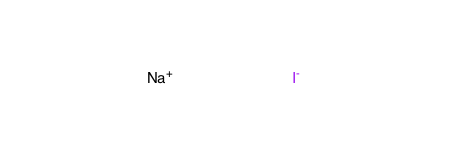

The leaving group is:  [Br-]


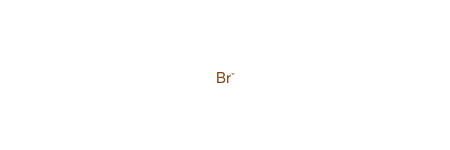

Your substrate is:  CCCBr


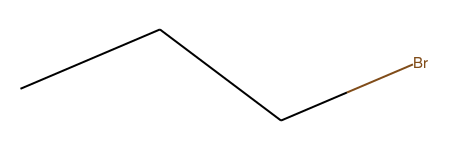

The reaction in SMILES format:  CCCBr.[Na+].[I-]>>[Br-].CCCI
The nucleophile '[Na+].[I-]' will perform a back side attack on the substrate 'CCCBr' and the leaving group '[Br-]' will detach from the substrate.


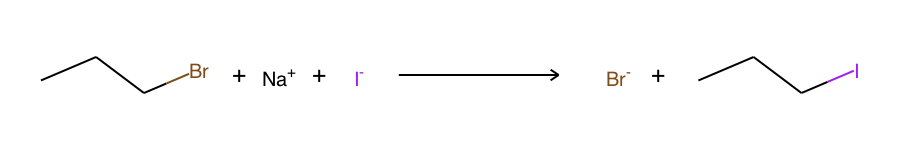

In [72]:
#Function called to display the result of the SN2 algorithm with two reactants (bromopropane and sodium iodide)

sn2Mol1 = 'CCCBr'
sn2Mol2 = '[Na+].[I-]'

subs(sn2Mol1, sn2Mol2)

In [57]:
#Below are different options you can choose from to input the reactants. The first option is to input the two reactant
#common name, and through restful services connected to a online chemical identifier, the function will conver the 
#common name to the SMILES string

#The second option is to use a PubChem plugin to draw the substrate with a leaving group in the list given.
#The plugin will produce a smiles string in which the user can copy and paste it into the textbox for the substrate
#with a leaving group. The second reactant (the nucleophile) can be chosen from a dropdown menu

In [111]:
#Option that allows you to enter the common name of the reactant (i.e. Sodium Hydroxide and Bromopropane)
inp = input("Enter a molecule name: ")
inp2 = input("Enter a molecule name: ")

if (' ' in inp):
    split = inp.split()
    part1 = split[0]
    part2 = split[1]
    s = ur.urlopen(("https://cactus.nci.nih.gov/chemical/structure/%s%%20%s/smiles") % (part1, part2))
    s1 = s.read()
    s1 = s1.decode('utf-8')
    print(s1)
if (' ' in inp2):
    split2 = inp2.split()
    part1 = split2[0]
    part2 = split2[1]
    s2 = ur.urlopen(("https://cactus.nci.nih.gov/chemical/structure/%s%%20%s/smiles") % (part1, part2))
    s3 = s2.read()
    s3 = s3.decode('utf-8')
    print(s3)
    
if (' ' not in inp):
    s = ur.urlopen(("https://cactus.nci.nih.gov/chemical/structure/%s/smiles") % inp)
    s1 = s.read()
    s1 = s1.decode('utf-8')
    print(x1)
if (' ' not in inp2):
    s2 = ur.urlopen(("https://cactus.nci.nih.gov/chemical/structure/%s/smiles") % inp2)
    s3 = s2.read()
    s3 = s3.decode('utf-8')
    print(s3)

Enter a molecule name: sodium hydroxide
Enter a molecule name: bromopropane
[OH-].[Na+]
CCCBr


The strong nucleophile is:  [OH-].[Na+]


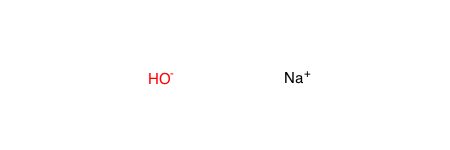

The leaving group is:  [Br-]


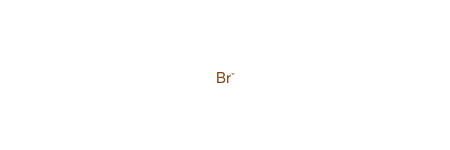

Your substrate is:  CCCBr


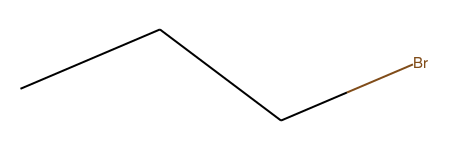

The reaction in SMILES format:  [OH-].[Na+].CCCBr>>[Br-].CCCO
The nucleophile '[OH-].[Na+]' will perform a back side attack on the substrate 'CCCBr' and the leaving group '[Br-]' will detach from the substrate.


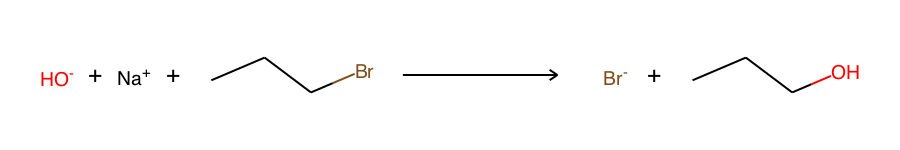

In [110]:
subs(s1, s3) #use this call if you are inputing the reactants by common name

In [24]:
import ipywidgets as widgets

In [29]:
#Dropdown option to enter the nucleophilic reactant
print('Please choose from the dropdown menu of nucleophiles: ')
options=['[OH-].[Na+]','C[O-].[Na+]', '[Li]C','[OH-].[K+]','[Na+].[C-]#N','[K+].[C-]#N',
             'C#[C-].[Na+]','[NH2-].[Na+]','[Li+].[Br-]','[K+].[I-]', 
             '[Na+].[N-]=[N+]=[N-]', '[Na+].CC[O-]', '[Na+].[I-]']
print(options)
nucleophile = widgets.Dropdown(options=options, value='[Na+].[I-]', description = "Nucleophile")
n = nucleophile.value
nucleophile

Please choose from the dropdown menu of nucleophiles: 
['[OH-].[Na+]', 'C[O-].[Na+]', '[Li]C', '[OH-].[K+]', '[Na+].[C-]#N', '[K+].[C-]#N', 'C#[C-].[Na+]', '[NH2-].[Na+]', '[Li+].[Br-]', '[K+].[I-]', '[Na+].[N-]=[N+]=[N-]', '[Na+].CC[O-]', '[Na+].[I-]']


In [26]:
#PubChem plug-in
print("If you choose to draw your reactants, please copy & paste the SMILES string (located in the top text box) for each reactant")
from IPython.core.display import display, HTML
display(HTML("""<iframe class="pubchem-widget" src="https://pubchem.ncbi.nlm.nih.gov/edit2/index.html" style="width: 100%; height: 500px;"></iframe>"""))

If you choose to draw your reactants, please copy & paste the SMILES string (located in the top text box) for each reactant


In [30]:
#Textbox option to enter the reactant with the leaving group from the plug-in
print('''Please enter the substrate as a SMILES string, as indicated in PubChem. 
Do not enter any aromatic rings. 
Be sure to have part of the substrate as a leaving group come from the list below:
      'Br', 'Cl', 'I', 'O', 'O[S]([O-])=O', 'O[S]([O-])(=O)=O','N' ''')
leavingGroup = widgets.Text(
    value='CCCBr',
    placeholder='Type something',
    description='Reactant with Leaving Group:',
    disabled=False
)
l = leavingGroup.value
leavingGroup

Please enter the substrate as a SMILES string, as indicated in PubChem. 
Do not enter any aromatic rings. 
Be sure to have part of the leaving group come from the list below:
      'Br', 'Cl', 'I', 'O', 'O[S]([O-])=O', 'O[S]([O-])(=O)=O','N' 


The strong nucleophile is:  [Na+].[I-]


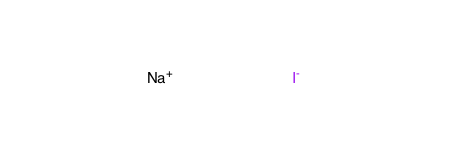

The leaving group is:  [Br-]


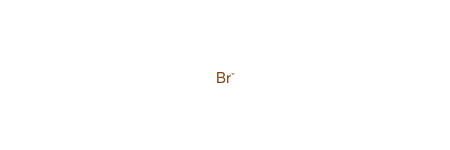

Your substrate is:  CCCBr


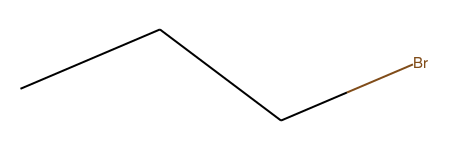

The reaction in SMILES format:  [Na+].[I-].CCCBr>>[Br-].CCCI
The nucleophile '[Na+].[I-]' will perform a back side attack on the substrate 'CCCBr' and the leaving group '[Br-]' will detach from the substrate.


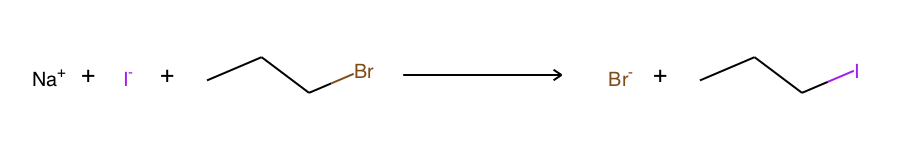

In [31]:
subs(n, l) #use this call if inputting the reactants from pubchem plug in and dropdown option